# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

**Submitted by:** 
Shibesh Kumar Chand and Abhay Saxena 

Note: We have tried out multiple experiments to arrive at best possible model for both 
1. Conv3D Model
2. CNN LSTM Model

Details of experiments have been provided in **Gesture_Recognition_Write_up.docx** file.

Please consider Conv3D Model here as the Final model, the weights obtained **model-00040-0.47512-0.83560-0.71869-0.76000.h5** has also been attached.

We have done this experiment using Google Collab and has installed required version of packages when needed.
Data set has been imported from Personal Google Drive mounted and same has been unzipped in the runtime. 

In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 92kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [ ]:
# mounting the google drive

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Unzipping the data set uploaded to gdrive

!unzip gdrive/MyDrive/Gesture_Recognition/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# defining generator function           
def generator(source_path, folder_list, batch_size, augment=False):
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
    
        for batch in range(num_batches): 
            batch_data, batch_labels= rt_batch_data(source_path,t,batch,batch_size,img_idx,augment)
            yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
    
        if (remaining_seq != 0):
            batch_data, batch_labels= rt_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
            yield batch_data, batch_labels 


def rt_batch_data(source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

    seq_len = remaining_seq if remaining_seq else batch_size

    batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,channels)) 
    batch_labels = np.zeros((seq_len,num_classes)) 

    if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),image_height,image_width,channels))

    
    for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
            # image reading and resizing
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=imresize(image,(image_height,image_width,3))
        
            #normalizing the images
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
        
            if (augment):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the image to obtain 
                cropped=shifted[x0:x1,y0:y1,:]
                # image reading and resizing
                image_resized=imresize(cropped,(image_height,image_width,3))
                # normalizing the images
                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
        
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        

    if (augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    
    return(batch_data,batch_labels)

In [ ]:
# Function to Train a model 

def train_model(model,batch_size,augment_data=False):
    train_generator = generator(train_path, train_doc, batch_size, augment=augment_data)
    val_generator = generator(val_path, val_doc, batch_size)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history


In [ ]:
# Function for Plotting

def drawplot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras import optimizers
from keras.layers import Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

**Conv3D Model:**

This is the best model we were able to create. We will consider this model as Final Model and weights obtained in this experiment has been attached. 

model-00040-0.47512-0.83560-0.71869-0.76000.h5

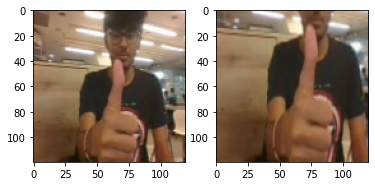

In [ ]:
# Checking for Data Augmentation

batch_size=3
total_frames= 30
frames_to_sample=16
image_height=120
image_width=120
channels=3
num_classes=5
g=generator(val_path,val_doc,batch_size,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

In [ ]:
# Initializing the Model training Paramenters

image_height=120
image_width=120
frames_to_sample=30
total_frames=30
batch_size=50
num_epochs=40
channels=3
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25
num_classes=5
augment_data=True

In [ ]:
 model = Sequential()
 model.add(Conv3D(8, filtersize, padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(16, filtersize, padding='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(32, filtersize, padding='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(64, filtersize, padding='same'))
 model.add(Activation('relu'))
 model.add(BatchNormalization())
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Flatten())
 model.add(Dense(dense_neurons,activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(dropout))

 model.add(Dense(dense_neurons,activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(dropout))


 model.add(Dense(num_classes,activation='softmax'))

 optimiser = optimizers.Adam(learning_rate=0.001)
 model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
 print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    6

In [ ]:
# Calling the train model function enabling data augmentation

history2 = train_model(model,batch_size,augment_data=True)

Epoch 1/40
14/14 [==============================] - 202s 15s/step - loss: 0.7229 - categorical_accuracy: 0.7323 - val_loss: 4.7575 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 4.75750, saving model to model_init_2021-06-1512_59_40.320855/model-00001-0.72293-0.73228-4.75750-0.18000.h5
Epoch 2/40
14/14 [==============================] - 205s 16s/step - loss: 0.6573 - categorical_accuracy: 0.7602 - val_loss: 4.6390 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss improved from 4.75750 to 4.63900, saving model to model_init_2021-06-1512_59_40.320855/model-00002-0.65728-0.76018-4.63900-0.24000.h5
Epoch 3/40
14/14 [==============================] - 199s 15s/step - loss: 0.6000 - categorical_accuracy: 0.7790 - val_loss: 4.5397 - val_categorical_accuracy: 0.2400

Epoch 00003: val_loss improved from 4.63900 to 4.53966, saving model to model_init_2021-06-1512_59_40.320855/model-00003-0.59997-0.77903-4.53966-0.24000.h5
Epoch 4/40
14/14 [=================

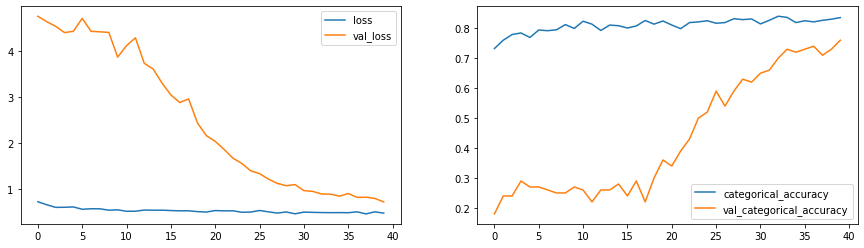

In [ ]:
drawplot(history2)

The model performed best after data augmentation. We were able to get good Accuracy score for both Training and Validation data thereby reducing the overfitting considerably.

We will use below generator function and train model function for CNN LSTM Model. This generator function helps in enabling few more data augmentation technique. CNN LSTM Model performed better with more data. 

In [ ]:
# defining generator function           
def generator_v2(source_path, folder_list, batch_size, augment=False):
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
    
        for batch in range(num_batches): 
            batch_data, batch_labels= rt_batch_data_v2(source_path,t,batch,batch_size,img_idx,augment)
            yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
    
        if (remaining_seq != 0):
            batch_data, batch_labels= rt_batch_data_v2(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
            yield batch_data, batch_labels 


def rt_batch_data_v2(source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

    seq_len = remaining_seq if remaining_seq else batch_size

    batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,channels)) 
    batch_labels = np.zeros((seq_len,num_classes)) 

    if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),image_height,image_width,channels))

    
    for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
            # image reading and resizing
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=imresize(image,(image_height,image_width,3))
        
            #normalizing the images
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
        
            if (augment):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the image to obtain 
                cropped=shifted[x0:x1,y0:y1,:]
                # image reading and resizing
                image_resized=imresize(cropped,(image_height,image_width,3))

                M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                                                np.random.randint(-10,10), 1.0)
                
                rotated = cv2.warpAffine(image_resized, M, (image_width, image_height))

                # normalizing the images
                batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
            
        
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        

    if (augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    
    return(batch_data,batch_labels)

# Function to Train a model 

def train_model_v2(model,batch_size,augment_data=False):
    train_generator = generator_v2(train_path, train_doc, batch_size, augment=augment_data)
    val_generator = generator_v2(val_path, val_doc, batch_size)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history


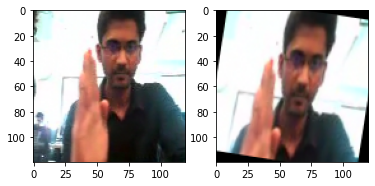

In [ ]:
# Checking for Data Augmentation

batch_size=3
total_frames= 30
frames_to_sample=30
image_height=120
image_width=120
channels=3
num_classes=5
g=generator_v2(val_path,val_doc,batch_size,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

**CNN LSTM Model:**

In [ ]:
# Initializing the Model training Paramenters

image_height=120
image_width=120
frames_to_sample=30
total_frames=30
batch_size=50
num_epochs=40
channels=3
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25
num_classes=5
lstm_cells=128
augment_data=True

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 8)   224       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 8)   32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    4

In [ ]:
history12=train_model_v2(model,batch_size,augment_data=True)

Epoch 1/40
14/14 [==============================] - 158s 12s/step - loss: 0.5023 - categorical_accuracy: 0.8107 - val_loss: 2.0346 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.03455, saving model to model_init_2021-06-1513_10_27.215477/model-00001-0.50234-0.81071-2.03455-0.21000.h5
Epoch 2/40
14/14 [==============================] - 166s 13s/step - loss: 0.4573 - categorical_accuracy: 0.8379 - val_loss: 1.9081 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 2.03455 to 1.90808, saving model to model_init_2021-06-1513_10_27.215477/model-00002-0.45725-0.83786-1.90808-0.26000.h5
Epoch 3/40
14/14 [==============================] - 169s 13s/step - loss: 0.4492 - categorical_accuracy: 0.8401 - val_loss: 1.9690 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.90808
Epoch 4/40
14/14 [==============================] - 169s 13s/step - loss: 0.4499 - categorical_accuracy: 0.8529 - val_loss: 2.0345 - val_cat

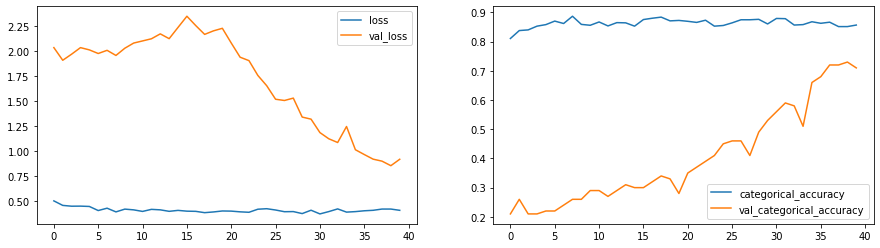

In [ ]:
drawplot(history12)

**Conclusion:**

Out of the best Conv3D Model and CNN LSTM Model mentioned above, we will consider **Conv3D Model** as our final model with weights **model-00040-0.47512-0.83560-0.71869-0.76000.h5**. As it provided better validation accuracy with less data to train.